### This document contains the transition functions for each of the examples that we use. 


For each example we will write the following functions:
- F from noise. 
- G from noise.
- f weight function
- g weight function.

And the Optimal Sample and Weight function where applicable.

In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax

## Constants

In [2]:
TAU = 1 / (256 * 8 * 60)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4
RHO = -0.75

# AR(1) Example

In [3]:
SIGMA_Y = 3.2

def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = last_val + TAU * KAPPA * (X_BAR - last_val)
    std = jnp.sqrt(TAU) * SIGMA_SIGMA
    next_val = noise * std + means
    return next_val


def ar1_g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """    
    return total_noise * jnp.sqrt(TAU) * SIGMA_Y + all_particles


In [4]:

def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)  # Mean reversion
    f_std = jnp.sqrt(TAU) * SIGMA_SIGMA  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 


def ar1_g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), particle, jnp.sqrt(TAU) * SIGMA_Y)



Optimal Functions

In [5]:
def ar1_optimal_sample(subkey, particles, Y_array, idt):

    mean_reversion_term = particles + TAU * KAPPA * (X_BAR - particles)
    optimal_var = (1 / (TAU * SIGMA_SIGMA**2) + 1 / (TAU * SIGMA_Y**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (TAU * SIGMA_SIGMA**2)) + (Y_array.at[idt].get() / (TAU * SIGMA_Y**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var
    
    new_particles = jax.random.normal(subkey, len(particles)) * jnp.sqrt(optimal_var) + optimal_mean
    
    return new_particles


def ar1_optimal_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    mean_reversion_term = particle + TAU * KAPPA * (X_BAR - particle)
    optimal_var = (1 / (TAU * SIGMA_SIGMA**2) + 1 / (TAU * SIGMA_Y**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (TAU * SIGMA_SIGMA**2)) + (Y_array.at[idt].get() / (TAU * SIGMA_Y**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), optimal_mean, jnp.sqrt(optimal_var))

ar1_optimal_likelihood_weight_fn = jax.vmap(ar1_optimal_likelihood_single, in_axes=(0, 0, None, None))


# Stochastic Volatility Example

In [6]:
# f from noise is same as before.

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = -0.5 * TAU * jnp.exp(2 * all_particles)
    y_stds = jnp.sqrt(TAU) * jnp.exp(all_particles)
    
    return total_noise * y_stds + y_means

In [7]:
# f likelihood is same as before

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    std = jnp.sqrt(TAU) * jnp.exp(prev_particle)  # full variance
    mean = -0.5 * std**2  # expected mean
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))


# Stochastic Volatility with Skew Example

In [8]:
# f from noise is same as before.

def skew_g_from_total_noise(prev_particle, particle, noise):
    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    return skew_total_mean + noise * jnp.sqrt(skew_total_var)

In [9]:
# f likelihood is same as before.

def skew_observation_weight_single(particle, prev_particle, Y_array, idt):

    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Skew-normal distribution parameters for Y[t]
    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO  * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    # Return log-likelihood: log P(Y[idt] | X_t, X_{t-1})
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), skew_total_mean, jnp.sqrt(skew_total_var))



# Testing Function as we go. 


### Data Generation.

We load up the PFVehicle for each of the examples, we then generate data from the examples. Plotting as we go, we should be able to notice the diffenrence

In [10]:
import matplotlib.pyplot as plt
from nnp_functions.pf_vehicle import PFVehicle

ar1_pf_vehicle = PFVehicle(f_from_noise, ar1_g_from_total_noise, f_likelihood_single, ar1_g_likelihood_single)
stoch_pf_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)
skew_pf_vehicle = PFVehicle(f_from_noise, skew_g_from_total_noise, f_likelihood_single, skew_observation_weight_single)


In [11]:
result = skew_pf_vehicle.generate_training_data(jax.random.PRNGKey(0), 100, 100, X_BAR)


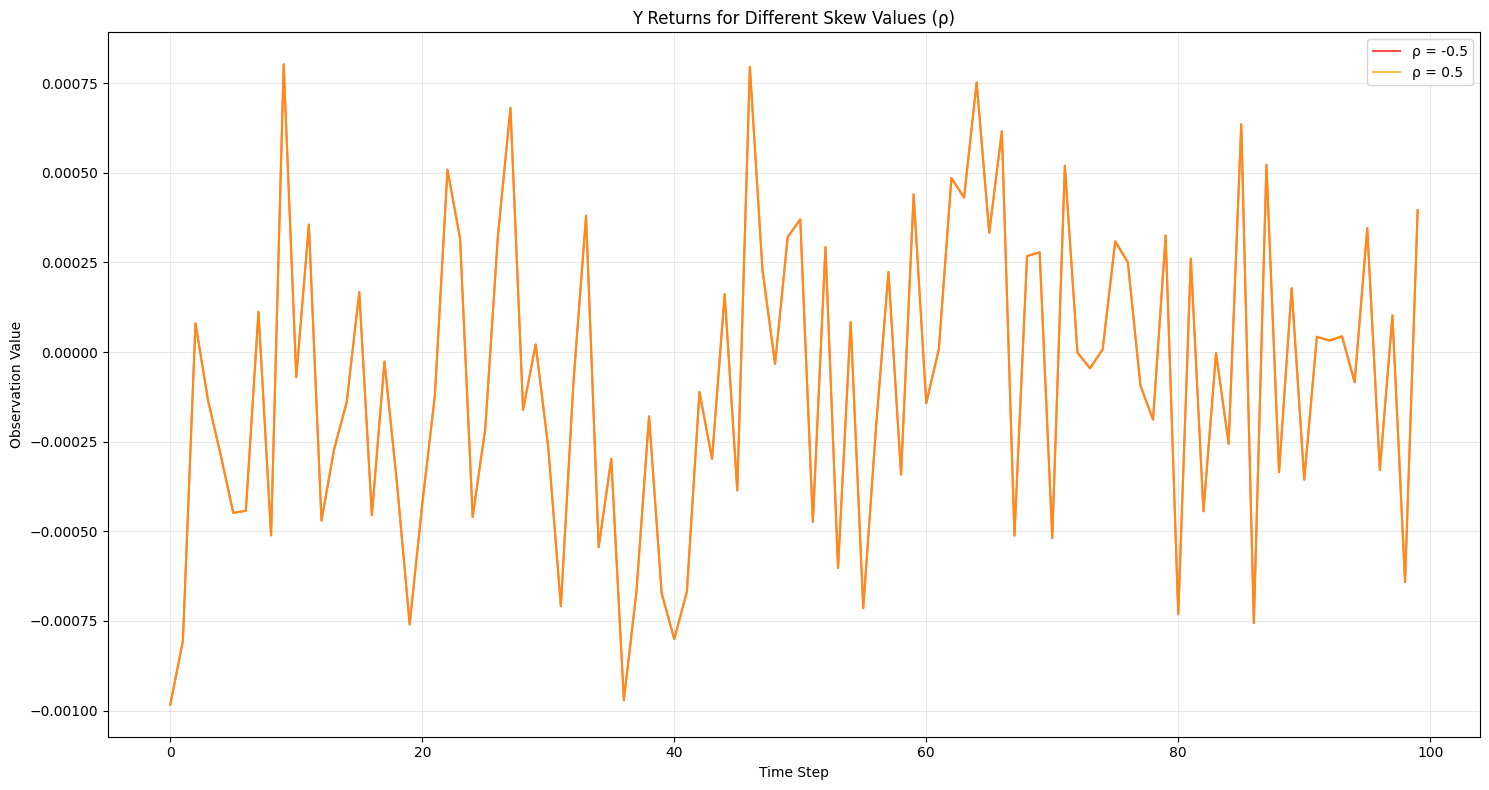

Summary statistics for different skew values:
--------------------------------------------------
ρ = -0.5: Mean =  -0.0001, Std =   0.0004, Min =  -0.0010, Max =   0.0008
ρ =  0.5: Mean =  -0.0001, Std =   0.0004, Min =  -0.0010, Max =   0.0008


In [12]:
## Plot y_returns for various skew values to see the effect

def get_noise(rho):
    def skew_g_from_total_noise(prev_particle, particle, noise):
        # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
        mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

        # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
        skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + rho * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)

        # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
        skew_total_var = TAU * jnp.exp(2 * particle) * (1 - rho**2)

        return skew_total_mean + noise * jnp.sqrt(skew_total_var)
    
    return skew_g_from_total_noise

# Test different skew values
skew_values = [-0.5, 0.5]
y_results = {}

for rho in skew_values:
    skew_pf_vehicle = PFVehicle(f_from_noise, get_noise(rho), f_likelihood_single, skew_observation_weight_single)
    x_data, y_data = skew_pf_vehicle.generate_data(jax.random.PRNGKey(0), 100, 100, X_BAR)
    y_results[rho] = y_data[0]  # Take first trajectory

# Plot results
plt.figure(figsize=(15, 8))
colors = ['red', 'orange', 'green', 'blue', 'purple']

for i, rho in enumerate(skew_values):
    plt.plot(y_results[rho], label=f'ρ = {rho}', color=colors[i], alpha=0.7)

plt.title('Y Returns for Different Skew Values (ρ)')
plt.xlabel('Time Step')
plt.ylabel('Observation Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also show summary statistics
print("Summary statistics for different skew values:")
print("-" * 50)
for rho in skew_values:
    y_data = y_results[rho]
    print(f"ρ = {rho:4.1f}: Mean = {jnp.mean(y_data):8.4f}, Std = {jnp.std(y_data):8.4f}, Min = {jnp.min(y_data):8.4f}, Max = {jnp.max(y_data):8.4f}")


This has made you doubt the skew model a bit, the main notieable effect happens by dampning the mean I feel that this wont be that accurate in practice.

### Testing the particle Filters.

The particle filter should run without issue for all of the data distributions. 

Before you can test you need to create the bootstrap sample function from f_from_noise_fn

In [13]:
def sample_fn_from_f_from_noise(f_from_noise_fn):
    
    def sample_fn(subkey, particles, Y_array, idt):
        return f_from_noise_fn(particles, jax.random.normal(subkey, len(particles)))
    
    return sample_fn

# We are now ready to test the particle filters




--- Testing Particle Filter: AR(1) ---
Final ESS: 878.28
Final mean estimate: -1.278
True final state: -1.261
Final MSE: 0.0003

--- Testing Particle Filter: Stochastic Volatility ---
Final ESS: 1918.86
Final mean estimate: -1.204
True final state: -1.261
Final MSE: 0.0032

--- Testing Particle Filter: Stochastic Volatility with Skew ---
Final ESS: 1285.70
Final mean estimate: -1.329
True final state: -1.261
Final MSE: 0.0047


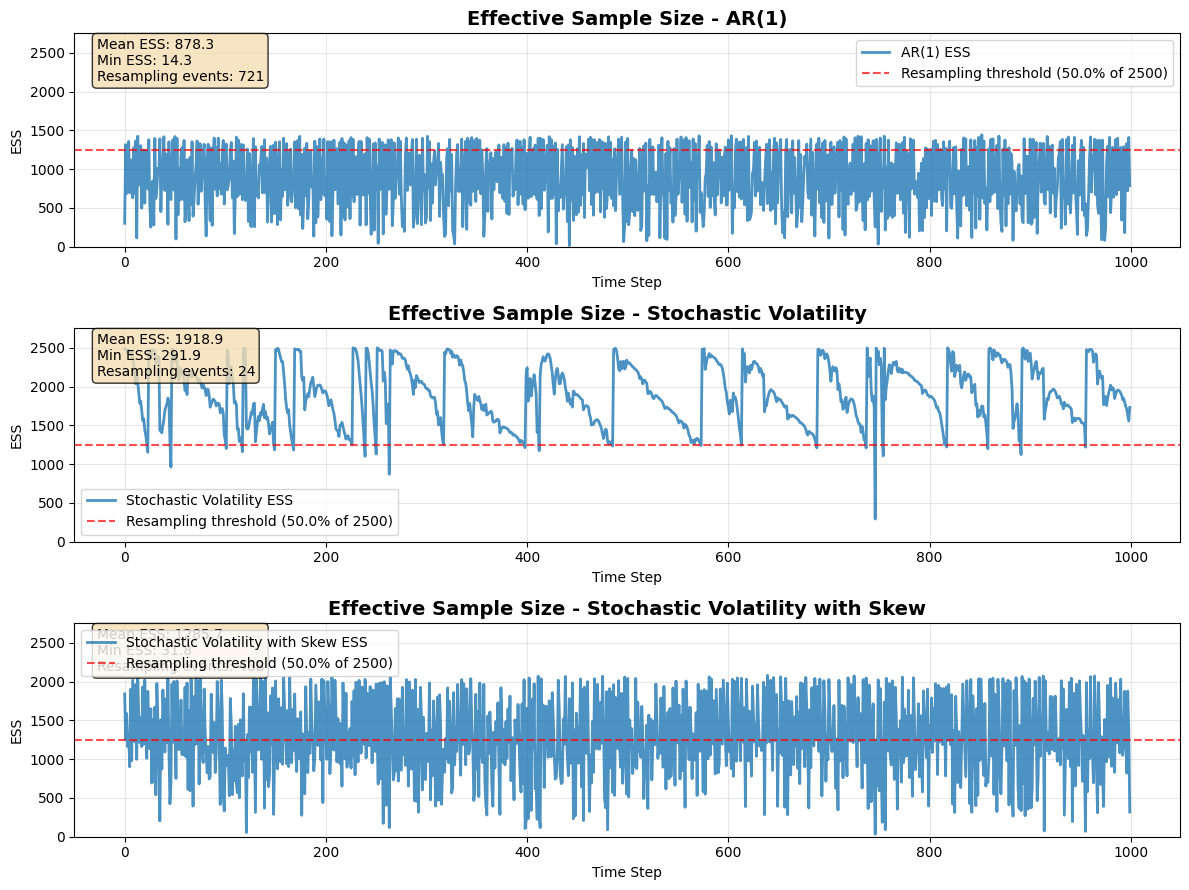

In [17]:
# --- Test Particle Filter for Each Example Using Simulated Data ---
import jax
from nnp_functions.particle_filter import ParticleFilter

# Settings
N_PARTICLES = 2500  # Number of particles for the filter
N_RUNS = 1         # Number of simulated runs (trajectories)
N_STEPS = 1000      # Number of time steps
SEED = 42

examples = [
    {
        'name': 'AR(1)',
        'vehicle': ar1_pf_vehicle,
        'sample_fn': sample_fn_from_f_from_noise(f_from_noise),
        'weight_fn': ar1_g_likelihood_single,
    },
    {
        'name': 'Stochastic Volatility',
        'vehicle': stoch_pf_vehicle,
        'sample_fn': sample_fn_from_f_from_noise(f_from_noise),
        'weight_fn': g_likelihood_single,
    },
    {
        'name': 'Stochastic Volatility with Skew',
        'vehicle': skew_pf_vehicle,
        'sample_fn': sample_fn_from_f_from_noise(f_from_noise),
        'weight_fn': skew_observation_weight_single,
    },
]

# Create a figure with subplots for ESS plots
fig, axes = plt.subplots(len(examples), 1, figsize=(12, 3*len(examples)))
if len(examples) == 1:
    axes = [axes]

for i, ex in enumerate(examples):
    print(f"\n--- Testing Particle Filter: {ex['name']} ---")
    key = jax.random.PRNGKey(SEED)
    # Generate simulated data
    X_paths, Y_paths = ex['vehicle'].generate_data(key, N_RUNS, N_STEPS, X_BAR)
    X_true = X_paths[0]  # shape: (N_STEPS,)
    Y_obs = Y_paths[0]   # shape: (N_STEPS,)

    # Set up initial particles and weights
    initial_particles = jax.random.normal(key, (N_PARTICLES,)) * 0.1 + X_BAR
    initial_log_weights = jnp.zeros(N_PARTICLES) - jnp.log(N_PARTICLES)

    # Instantiate ParticleFilter
    pf = ParticleFilter(
        sample_fn=ex['sample_fn'],
        weight_fn=ex['weight_fn'],
        N_PARTICLES=N_PARTICLES
    )

    # Run the filter
    out_particles, out_log_weights, diagnostics = pf.simulate(
        key, initial_particles, initial_log_weights, Y_obs, X_true
    )

    # Plot ESS with improved styling
    ess_values = diagnostics['ess']
    time_steps = jnp.arange(len(ess_values))
    
    axes[i].plot(time_steps, ess_values, linewidth=2, alpha=0.8, label=f'{ex["name"]} ESS')
    axes[i].axhline(y=N_PARTICLES * pf.ESS_COND, color='red', linestyle='--', alpha=0.7, 
                   label=f'Resampling threshold ({pf.ESS_COND:.1%} of {N_PARTICLES})')
    axes[i].set_title(f'Effective Sample Size - {ex["name"]}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('ESS')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, N_PARTICLES * 1.1)
    
    # Add text box with summary statistics
    average_ess = jnp.mean(ess_values)
    min_ess = jnp.min(ess_values)
    resampling_events = jnp.sum(diagnostics['resample_flag'])
    textstr = f'Mean ESS: {average_ess:.1f}\nMin ESS: {min_ess:.1f}\nResampling events: {resampling_events}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axes[i].text(0.02, 0.98, textstr, transform=axes[i].transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

    # Print diagnostics
    mean_est = jnp.average(out_particles, weights=jnp.exp(out_log_weights))
    mse = ((mean_est - X_true[-1]) ** 2).item()
    print(f"Final ESS: {average_ess:.2f}")
    print(f"Final mean estimate: {mean_est:.3f}")
    print(f"True final state: {X_true[-1]:.3f}")
    print(f"Final MSE: {mse:.4f}")

plt.tight_layout()
plt.show()